# How-to Guide: Capturing stdout with CWL

This guide explains how to capture the standard output (`stdout`) of a `CommandLineTool` in CWL.

The example focuses on the `stdout` and `outputs` blocks to save the tool's output to a file and make it available for further use.

## Objective

Capture the `stdout` of a command and make it accessible as a workflow output using:

In [4]:
cat ../cwl/02-stdout/capture-stdout.cwl | yq e .'$graph[1]' | tail -n 8

stdout: message
outputs:
  info:
    type: string
    outputBinding:
      glob: message
      loadContents: true
      outputEval: $(self[0].contents)


## Steps

1. Understand the stdout Block

The `stdout` field specifies the file where the standard output of the `CommandLineTool` should be redirected. In this example:


In [15]:
yq '.. | select(has("stdout")) | {"stdout": .stdout}'  ../cwl/02-stdout/capture-stdout.cwl

stdout: message


2. Understand the outputs Block

The `outputs` block defines how to extract information from the `stdout` file:

In [18]:
cat ../cwl/02-stdout/capture-stdout.cwl | yq e .'$graph[1]' | yq '.. | select(has("outputs")) | {"outputs": .outputs}' 

outputs:
  info:
    type: string
    outputBinding:
      glob: message
      loadContents: true
      outputEval: $(self[0].contents)


3. Review the CWL File

Here’s the complete example (`capture-stdout.cwl`):

In [19]:
yq -e . ../cwl/02-stdout/capture-stdout.cwl

cwlVersion: v1.2
$graph:
  - class: Workflow
    id: main
    inputs:
      tif:
        type: string
    outputs:
      info:
        outputSource: step-info/info
        type: string
    steps:
      step-info:
        in:
          geotif: tif
        out:
          - info
        run: "#rio"
  - class: CommandLineTool
    id: rio
    requirements:
      NetworkAccess:
        networkAccess: true
      InlineJavascriptRequirement: {}
      DockerRequirement:
        dockerPull: ghcr.io/eoap/how-to/how-to-container:1.1.0
    baseCommand: rio
    arguments:
      - info
      - $(inputs.geotif)
    inputs:
      geotif:
        type: string
    stdout: message
    outputs:
      info:
        type: string
        outputBinding:
          glob: message
          loadContents: true
          outputEval: $(self[0].contents)


It's graphical representation:

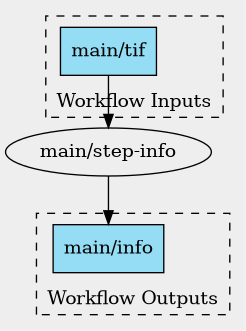

In [27]:
cwltool --print-dot ../cwl/02-stdout/capture-stdout.cwl 2> /dev/null | dot -Tpng | display

4. Provide an Input

For this example, use the input file (or command-line argument) to specify the GeoTIFF:

```bash
cwltool ../cwl/02-stdout/capture-stdout.cwl \
    --tif "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/10/T/FK/2021/7/S2B_10TFK_20210713_0_L2A/TCI.tif"
```

5. Execute the CWL Tool

Run the command in your terminal:

```bash
cwltool capture-stdout.cwl \
    --tif "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/10/T/FK/2021/7/S2B_10TFK_20210713_0_L2A/TCI.tif" > output.json
```

In [23]:
cwltool ../cwl/02-stdout/capture-stdout.cwl \
    --tif "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/10/T/FK/2021/7/S2B_10TFK_20210713_0_L2A/TCI.tif" > output.json

INFO /home/fbrito/.local/bin/cwltool 3.1.20240508115724
INFO Resolved '../cwl/02-stdout/capture-stdout.cwl' to 'file:///data/work/github/eoepca-plus/how-to/cwl/02-stdout/capture-stdout.cwl'
INFO [workflow ] start
INFO [workflow ] starting step step-info
INFO [step step-info] start
INFO [job step-info] /tmp/9rwgfcsh$ docker \
    run \
    -i \
    --mount=type=bind,source=/tmp/9rwgfcsh,target=/QfmLfw \
    --mount=type=bind,source=/tmp/vps1rd7a,target=/tmp \
    --workdir=/QfmLfw \
    --read-only=true \
    --log-driver=none \
    --user=1000:1000 \
    --rm \
    --cidfile=/tmp/ejk54za_/20241229125633-551835.cid \
    --env=TMPDIR=/tmp \
    --env=HOME=/QfmLfw \
    ghcr.io/eoap/how-to/how-to-container:1.1.0 \
    rio \
    info \
    https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/10/T/FK/2021/7/S2B_10TFK_20210713_0_L2A/TCI.tif > /tmp/9rwgfcsh/message
INFO [job step-info] Max memory used: 46MiB
INFO [job step-info] completed success
INFO [step step-info] comple

## Expected Output

The `rio info` command processes the GeoTIFF file, and its output is written to the `message` file. The workflow then captures this file’s contents as the `info` output.

Sample output:

In [28]:
cat output.json | yq e . -o=json

{
  "info": "{\"blockxsize\": 1024, \"blockysize\": 1024, \"bounds\": [600000.0, 4390200.0, 709800.0, 4500000.0], \"colorinterp\": [\"red\", \"green\", \"blue\"], \"compress\": \"deflate\", \"count\": 3, \"crs\": \"EPSG:32610\", \"descriptions\": [null, null, null], \"driver\": \"GTiff\", \"dtype\": \"uint8\", \"height\": 10980, \"indexes\": [1, 2, 3], \"interleave\": \"pixel\", \"lnglat\": [-121.18160686746373, 40.1419732942866], \"mask_flags\": [[\"nodata\"], [\"nodata\"], [\"nodata\"]], \"nodata\": 0.0, \"res\": [10.0, 10.0], \"shape\": [10980, 10980], \"tiled\": true, \"transform\": [10.0, 0.0, 600000.0, 0.0, -10.0, 4500000.0, 0.0, 0.0, 1.0], \"units\": [null, null, null], \"width\": 10980}\n"
}


## Key Takeaways

* `stdout` Field: Redirects the standard output to a specified file.
* `outputs` Block:
  * Uses `glob` to locate the file.
  * Loads the file's contents into memory with `loadContents: true`.
  * Extracts and evaluates the contents with `outputEval`.

By focusing on the `stdout` and `outputs` blocks, this guide helps you capture and use command outputs in CWL workflows.